# Fish experiment whole dataset


## Hyperparameters

In [2]:

#torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import optim
#Libaries for calculation and processing
from einops import rearrange, repeat
import math
from math import sqrt
from math import ceil
import numpy as np
from sklearn.preprocessing import StandardScaler
#libaries for data importng, formating and handling 
import pandas as pd
#For analysis and plotting
import matplotlib.pyplot as plt
import seaborn as sns
#others
import os
import time
import json
import pickle
import warnings
warnings.filterwarnings('ignore')
import random

from model.Crossformer import *
from data.Dataset import Dataset_MTS,Dataset_MTS_simplified
from exp.ExpFish import Expfish

In [7]:
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt

def apply_butterworth_bandpass_filter(df, column_names, lowcut, highcut, fs, order=5):
    # Design the Butterworth bandpass filter
    nyq = 0.5 * fs  # Nyquist Frequency
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')

    # Apply the filter to each specified column in the DataFrame
    for column in column_names:
        df[column] = filtfilt(b, a, df[column].values)
    
    return df

In [3]:

#DATASET 
ROOT_PATH = "data/DatasetClusters/fishes/fish02/"
DATA_PATH = "fish_02_pairs.csv"

ROOT_PATH_VAL= "data/DatasetClusters/fishes/"
DATA_PATH_VAL= "validation.csv"

TRAIN_FLAG = "train"
VAL_FLAG = "val"
TEST_FLAG = "test"
SIZE=[1031,1031,1031] #[seq_len, label_len, pred_len]
SCALE = True
SCALE_STATISTIC = True
DATA_SPLIT = [1, 0, 0.0]  # Train, Val, TEST
STRIDE = 1

#DATALOADER 
BATCH_SIZE = 100
SHUFFLE_FLAG = False
NUM_WORKSES = 0
DROP_LAST = False

#MODEL 
DATA_DIM = 768  # number of clusers
IN_LEN   = SIZE[0]
OUT_LEN  = SIZE[2]
SEG_LEN  = 10
WIN_SIZE = 1
FACTOR   = 1
D_MODEL  = 256
D_FF     = 512
N_HEADS  = 8
E_LAYERS = 1
DROPOUT  = 0.1
BASELINE = False

#Device
DEVICE   = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#OPTIMIZER
LR = 0.001

#TRAINING 
NUM_EPOCHS = 10



In [19]:
DEVICE



device(type='cuda')

In [4]:
def set_seed(seed):
    """Sets the seed for reproducibility."""
    torch.manual_seed(seed) 
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Example of setting a seed
set_seed(47)

## Setting up pairs


In [5]:
def get_column_pair(df, pair_number):
    # Calculate indices for the desired pair directly from pair_number using zero-based indexing
    index1 = pair_number * 2
    index2 = index1 + 1
    
    # Check if indices are within the column range
    if index2 < len(df.columns):
        # Return the selected columns
        return df.iloc[:, index1:index2 + 1]
    else:
        # Return an empty DataFrame or raise an error if the pair number is invalid
        return pd.DataFrame()

In [8]:
df_data_train = pd.read_csv(ROOT_PATH+DATA_PATH)
tmp = df_data_train.copy()
#df_data = get_column_pair(df_data,2)
df_data_vali = apply_butterworth_bandpass_filter(tmp,tmp.columns,0.1,5,80)
#df_data_vali = pd.read_csv("data/validation.csv")
#df_data_vali

## DataLoader

In [9]:

#train_set = Dataset_MTS(root_path=ROOT_PATH,data_path=DATA_PATH,flag=TRAIN_FLAG,size=SIZE,scale=SCALE,scale_statistic=SCALE_STATISTIC,data_split=DATA_SPLIT,stride=STRIDE)

train_set = Dataset_MTS_simplified(df_data=df_data_train,df_filt=None,size=SIZE,stride=STRIDE)

vali_set = Dataset_MTS_simplified(df_data=df_data_vali,df_filt=None,size=SIZE,stride=STRIDE)

data_loader_train = DataLoader(
            train_set,
            batch_size=BATCH_SIZE,
            shuffle=SHUFFLE_FLAG,
            num_workers=NUM_WORKSES,
            drop_last=DROP_LAST
            )

data_loader_vali = DataLoader(
            vali_set,
            batch_size=BATCH_SIZE,
            shuffle=SHUFFLE_FLAG,
            num_workers=NUM_WORKSES,
            drop_last=DROP_LAST
            )

In [10]:
for first_batch in data_loader_train:
    # 'first_batch' now holds the first batch of your data.
    # Do something with 'first_batch', for example, process it or print it.
    m = first_batch
    break 



In [11]:
DEVICE

device(type='cuda')

In [26]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    # Print the number of GPUs available
    print("Number of CUDA Devices:", torch.cuda.device_count())
    
    # Print details of each CUDA device
    for i in range(torch.cuda.device_count()):
        print("Device", i, ":", torch.cuda.get_device_name(i))
else:
    print("CUDA is not available.")

Number of CUDA Devices: 1
Device 0 : NVIDIA A100-PCIE-40GB


## Model Init


In [27]:
model = Crossformer(
    data_dim=DATA_DIM,
    in_len=IN_LEN,
    out_len=OUT_LEN,
    seg_len=SEG_LEN,
    win_size=WIN_SIZE,
    factor=FACTOR,
    d_model=D_MODEL,
    d_ff=D_MODEL,
    n_heads=N_HEADS,
    e_layers=E_LAYERS,
    dropout=DROPOUT,
    baseline=False,
    device=DEVICE
    
).float()

## Loss-function and Optimizer

In [18]:
criterion = nn.MSELoss()
#criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

NameError: name 'model' is not defined

## Training

In [29]:
exp = Expfish(model=model,
               data_loader_train=data_loader_train,
               data_loader_test=data_loader_vali,
               data_loader_val=data_loader_vali,
               optimizer=optimizer,
               criterion=criterion,
               num_epochs=NUM_EPOCHS,
               device=DEVICE,
               scheduler = scheduler
               )


In [30]:
exp.train()

START TRAINING :
Epoch: 1 cost time: 98.11782836914062
Epoch: 1, Steps: 1 | Train Loss: 1.3361288 Vali Loss: 0.0000000
Epoch: 2 cost time: 96.83431506156921
Epoch: 2, Steps: 1 | Train Loss: 0.8835285 Vali Loss: 0.0000000
Epoch: 3 cost time: 95.1049211025238
Epoch: 3, Steps: 1 | Train Loss: 0.5518486 Vali Loss: 0.0000000
Epoch: 4 cost time: 96.12850069999695
Epoch: 4, Steps: 1 | Train Loss: 0.3367593 Vali Loss: 0.0000000
Epoch: 5 cost time: 95.7691879272461
Epoch: 5, Steps: 1 | Train Loss: 0.2173906 Vali Loss: 0.0000000
Epoch: 6 cost time: 131.72566652297974
Epoch: 6, Steps: 1 | Train Loss: 0.1562498 Vali Loss: 0.0000000
Epoch: 7 cost time: 196.10841059684753
Epoch: 7, Steps: 1 | Train Loss: 0.1231640 Vali Loss: 0.0000000
Epoch: 8 cost time: 197.27559208869934
Epoch: 8, Steps: 1 | Train Loss: 0.0994517 Vali Loss: 0.0000000
Epoch: 9 cost time: 195.38856554031372
Epoch: 9, Steps: 1 | Train Loss: 0.0846563 Vali Loss: 0.0000000
Epoch: 10 cost time: 181.2302725315094
Epoch: 10, Steps: 1 | Tr

Crossformer(
  (enc_value_embedding): DSW_embedding(
    (linear): Linear(in_features=10, out_features=256, bias=True)
  )
  (pre_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (encoder): Encoder(
    (encode_blocks): ModuleList(
      (0): scale_block(
        (encode_layers): ModuleList(
          (0): TwoStageAttentionLayerCrossSegmentsMultiMTS(
            (dim_senders): ModuleList(
              (0-383): 384 x AttentionLayerCrossSegments(
                (inner_attention1): FullAttention(
                  (dropout): Dropout(p=0.1, inplace=False)
                )
                (inner_attention2): FullAttention(
                  (dropout): Dropout(p=0.1, inplace=False)
                )
                (query_projection): Linear(in_features=256, out_features=256, bias=True)
                (key_projection): Linear(in_features=256, out_features=256, bias=True)
                (value_projection): Linear(in_features=256, out_features=256, bias=True)
               

In [16]:
#torch.save(model,"crossModel/REC_BASE.pth")
#NEW
torch.save(model,"crossModel/TOPS/REC_INDEPENDENT_8_HEAD_ENC9_DEC9_COMBINED.pth")
#torch.save(model,"crossModel/REC_4_HEAD_CROSS_2_OLD_CROSS_DEC_CROSS_ENC52_DEC10.pth")
#torch.save(model,"crossModel/REC_synt.pth")

In [ ]:
tsa_layer_decoder = model.decoder

In [ ]:
tsa_layer_decoder.decode_layers[0].self_attention.get_attn()

# Model EVAL

In [13]:


test_set = Dataset_MTS_simplified(df_data=df_data_train,size=SIZE,stride=STRIDE)

data_loader_test = DataLoader(
            test_set,
            batch_size=BATCH_SIZE,
            shuffle=SHUFFLE_FLAG,
            num_workers=NUM_WORKSES,
            drop_last=DROP_LAST
            )


In [19]:
model_recon = torch.load(f"crossModel/TOPS/REC_INDEPENDENT_8_HEAD_ENC9_DEC9_COMBINED.pth")

In [20]:
criterion = nn.MSELoss()
#criterion = nn.L1Loss()
optimizer = optim.Adam(model_recon.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

In [21]:
exp_eval = Expfish(model=model_recon,
               data_loader_train=None,
               data_loader_test=data_loader_test,
               data_loader_val=data_loader_test,
               optimizer=optimizer,
               criterion=criterion,
               num_epochs=NUM_EPOCHS,
               device=DEVICE,
               scheduler = scheduler
               )

    

In [22]:
exp_eval.eval("REC_INDEPENDENT_8_HEAD_ENC9_DEC9_COMBINED",save_pred=True)

mse:0.06322558969259262, mae:0.19955436885356903


In [23]:
tsa_layer_decoder = model_recon.decoder.decode_layers[1].self_attention.get_attn()
tsa_layer_decoder[0]

IndexError: index 1 is out of range

In [24]:
true = np.load("results/REC_INDEPENDENT_8_HEAD_ENC9_DEC9_COMBINED/true.npy")
pred = np.load("results/REC_INDEPENDENT_8_HEAD_ENC9_DEC9_COMBINED/pred.npy")


In [25]:
# Reshape arrays to remove the extra dimension
true = true.squeeze()
pred = pred.squeeze()

# Reshape true and predicted arrays into 2D arrays (1031 rows x 768 columns)
true_df = pd.DataFrame(true.reshape(-1, true.shape[-1]))
pred_df = pd.DataFrame(pred.reshape(-1, pred.shape[-1]))

In [26]:
import plotly.graph_objects as go


def plot_true_vs_pred(true_df, pred_df, df_data_train,i):
    # Assuming 'i' is a column name, retrieve column data from dataframes
    true_series = true_df[i]
    pred_series = pred_df[i]
    trained_df  = df_data_train.iloc[:,i]

    # Create a Plotly figure
    fig = go.Figure()

    # Add traces for true and predicted values
    # Here, the 'x' values use the index of the dataframe
    fig.add_trace(go.Scatter(x=true_series.index, y=true_series, mode='lines', name='True', line=dict(color='blue')))
    fig.add_trace(go.Scatter(x=pred_series.index, y=pred_series, mode='lines', name='Predicted', line=dict(color='red')))
    #fig.add_trace(go.Scatter(x=pred_series.index, y=trained_df, mode='lines', name='Predicted', line=dict(color='green')))

    # Update layout for a better visualization
    fig.update_layout(
        title=f'True vs Predicted Time Series for {i}',
        xaxis_title='Index',
        yaxis_title='Values',
        legend_title='Variable',
        dragmode='zoom'  # This enables dragging behavior
    )

    # Show the figure
    fig.show()



In [99]:

def plot_true_vs_pred2(true_df, pred_df, df_data_train, i):
    # Assuming 'i' is a column name, retrieve column data from dataframes
    true_series = true_df[i]
    pred_series = pred_df[i]
    trained_series = df_data_train.iloc[:,i]

    # Create a Matplotlib figure
    plt.figure(figsize=(12, 6))

    # Plot true and predicted values
    plt.plot(true_series.index, true_series, label='True', color='blue')
    plt.plot(pred_series.index, pred_series, label='Reconstructed', color='red')
    # Uncomment the line below if you want to plot the trained data
    # plt.plot(trained_series.index, trained_series, label='Trained', color='green')

    # Update layout for a better visualization
    plt.title(r'True vs Reconstructed: $S_{E8}(t)$',fontsize=20, fontweight='bold')
    plt.xlabel('time (t)',fontsize=20)
    plt.ylabel(r'$\Delta F / F$', fontsize=20)
    plt.legend(fontsize=14)
    plt.grid(True)

    # Save the plot as an image file (optional)
    plt.savefig(f'true_vs_pred_{i}.png', dpi=300, bbox_inches='tight')

    # Show the figure
    plt.show()


In [100]:
column_name = df_data_train.columns[111]

print(column_name)

cluster_8_green_s1_paired.2


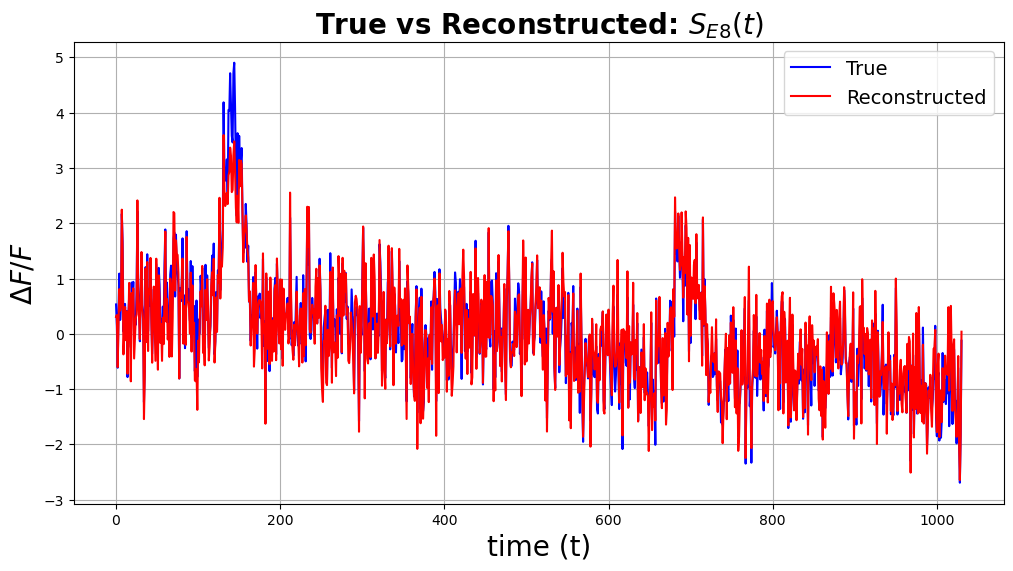

In [101]:
plot_true_vs_pred2(true_df,pred_df,df_data_train,111)

In [28]:
from sklearn.metrics import mean_squared_error

def find_top_mse(true_df,pred_df):
    mse_dict = {}
    # Calculate MSE for each series in the dataframe
    for i in true_df.columns:  # Assuming column indices match in true_df and pred_df
        true_series = true_df[i]
        pred_series = pred_df[i]
        mse = mean_squared_error(true_series, pred_series)
        mse_dict[i] = mse

    # Convert dictionary to a list of tuples and sort by MSE
    sorted_mse = sorted(mse_dict.items(), key=lambda x: x[1])

    # Extract top 5 best and worst MSEs
    top_5_best = sorted_mse[:5]
    top_5_worst = sorted_mse[-5:]

    # Calculate mean MSE across all series
    mean_mse = sum(mse_dict.values()) / len(mse_dict)

    # Printing the results
    print("Top 5 Best MSEs:")
    for series, mse in top_5_best:
        print(f"Series {series}: MSE = {mse:.4f}")
        
    print("\nTop 5 Worst MSEs:")
    for series, mse in top_5_worst:
        print(f"Series {series}: MSE = {mse:.4f}")
    
    print(f"\nMean MSE Across All Series: {mean_mse:.4f}")

    return sorted_mse

In [29]:
find_top_mse(true_df,pred_df)

Top 5 Best MSEs:
Series 390: MSE = 0.0483
Series 317: MSE = 0.0496
Series 348: MSE = 0.0501
Series 96: MSE = 0.0502
Series 100: MSE = 0.0509

Top 5 Worst MSEs:
Series 459: MSE = 0.0825
Series 111: MSE = 0.0831
Series 507: MSE = 0.0834
Series 603: MSE = 0.0849
Series 714: MSE = 0.0853

Mean MSE Across All Series: 0.0632


[(390, 0.048251178),
 (317, 0.04957602),
 (348, 0.05010133),
 (96, 0.050234612),
 (100, 0.050918587),
 (236, 0.051013585),
 (655, 0.051380172),
 (232, 0.05139243),
 (689, 0.051415186),
 (629, 0.05147837),
 (565, 0.051572803),
 (577, 0.05164415),
 (609, 0.05165337),
 (722, 0.051784318),
 (299, 0.051789872),
 (746, 0.05206133),
 (476, 0.052108563),
 (126, 0.052226927),
 (703, 0.052235935),
 (659, 0.052498102),
 (720, 0.052733723),
 (8, 0.05283887),
 (593, 0.052907497),
 (517, 0.052942026),
 (212, 0.052942056),
 (753, 0.053110182),
 (501, 0.053133972),
 (282, 0.053217404),
 (760, 0.053305883),
 (407, 0.05347635),
 (762, 0.053592175),
 (0, 0.053727325),
 (646, 0.053775538),
 (610, 0.05395029),
 (185, 0.05401299),
 (218, 0.05402204),
 (669, 0.05407657),
 (287, 0.054204643),
 (292, 0.054243952),
 (436, 0.054274898),
 (340, 0.05428503),
 (264, 0.054309465),
 (732, 0.054316554),
 (266, 0.054382443),
 (270, 0.054550365),
 (51, 0.054604027),
 (465, 0.05464249),
 (210, 0.054685917),
 (652, 0.0547

In [30]:
true_series = true_df[6]
pred_series = pred_df[6]

mse = mean_squared_error(true_series, pred_series)

mse

0.060419

# Pair wise

In [ ]:
def get_column_pair(df, pair_number):
    # Calculate indices for the desired pair directly from pair_number using zero-based indexing
    index1 = pair_number * 2
    index2 = index1 + 1
    
    # Check if indices are within the column range
    if index2 < len(df.columns):
        # Return the selected columns
        return df.iloc[:, index1:index2 + 1]
    else:
        # Return an empty DataFrame or raise an error if the pair number is invalid
        return pd.DataFrame()

In [ ]:

#DATASET 
ROOT_PATH = "data/DatasetClusters/fishes/fish02/"
DATA_PATH = "fish_02_pairs.csv"

TRAIN_FLAG = "train"
VAL_FLAG = "val"
TEST_FLAG = "test"
SIZE=[100,100,100] #[seq_len, label_len, pred_len]
SCALE = True
SCALE_STATISTIC = True
DATA_SPLIT = [1, 0, 0.0]  # Train, Val, TEST
STRIDE = 25

#DATALOADER 
BATCH_SIZE = 100
SHUFFLE_FLAG = False
NUM_WORKSES = 0
DROP_LAST = False

#MODEL 
DATA_DIM = 2  # number of clusers
IN_LEN   = SIZE[0]
OUT_LEN  = SIZE[2]
SEG_LEN  = 10
WIN_SIZE = 1
FACTOR   = 1
D_MODEL  = 256 
D_FF     = 512
N_HEADS  = 4
E_LAYERS = 1
DROPOUT  = 0.0
BASELINE = False

#Device
DEVICE   = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#OPTIMIZER
LR = 0.001

#TRAINING 
NUM_EPOCHS = 50



In [ ]:
def set_seed(seed):
    """Sets the seed for reproducibility."""
    torch.manual_seed(seed) 
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Example of setting a seed
set_seed(47)

In [ ]:

df_data = pd.read_csv(ROOT_PATH+DATA_PATH)
    
number_of_pairs = int(len(df_data.T)/2)


for i in range(number_of_pairs):
    df_data_i= get_column_pair(df_data,i)

    train_set = Dataset_MTS_simplified(df_data=df_data_i,size=SIZE,stride=STRIDE)

    data_loader_train = DataLoader(
                train_set,
                batch_size=BATCH_SIZE,
                shuffle=SHUFFLE_FLAG,
                num_workers=NUM_WORKSES,
                drop_last=DROP_LAST
                )
    model = Crossformer(
        data_dim=DATA_DIM,
        in_len=IN_LEN,
        out_len=OUT_LEN,
        seg_len=SEG_LEN,
        win_size=WIN_SIZE,
        factor=FACTOR,
        d_model=D_MODEL,
        d_ff=D_MODEL,
        n_heads=N_HEADS,
        e_layers=E_LAYERS,
        dropout=DROPOUT,
        baseline=False,
        device=DEVICE
        
    ).float()

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.96)

    
    exp = Expfish(model=model,
               data_loader_train=data_loader_train,
               data_loader_test=None,
               data_loader_val=None,
               optimizer=optimizer,
               criterion=criterion,
               num_epochs=NUM_EPOCHS,
               device=DEVICE,
               scheduler = scheduler
               )

    model = exp.train()



    torch.save(model,f"crossModel/4Head/model_pair_{i}.pth")

In [ ]:





    #torch.save(model,f"crossModel/BestPred/model_pair_{i}.pth")